# Project: Investigate TMDB Movies Dataset

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#functions">Functions Python</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

The dataset is from the [TMDB](https://www.themoviedb.org/) website. He gather data from little less than 5.000 movies, with interesting fields like budget, revenue, runtime, genres and keywords.

I plan to answer some questions like:
1. Which gender is the most frequent?
2. What is the average budget?
3. What is the average revenue?
4. Except english, What language is more frequently in the movies?
5. Do high-budget movies have more or less producers involved? What about low budget films?
6. Which genre is associated with the best average vote? And with the smallest?
7. What is the characteristics of movies that have and do not have webpages?
8. Do long runtime movies have low or high average votes?
9. Which films are associated with the most used keyword?

In [1]:
# Import packages to data analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patches as mpatches
import seaborn as sn
import json
import zipfile

# Packages to use in get_language_codes func
import requests
import lxml.html as lh
from bs4 import BeautifulSoup

# Magic keywords and plot grid style
%matplotlib inline
sn.set_style('darkgrid')

<a id='functions'></a>
## Functions Python

I see the oportunite to get names os languages from column original_language using 'scrap' method.
Searching in google, i found the pattern of names in [ISO website](https://www.iso.org/iso-639-language-codes.html).<br>Also I got a function from Matplotlib website to format the y axis from a plot.

The functions is described below.

**Obs.** The references of website I visit to construct this functions is in references.txt file

### Python scraping function

In [2]:
def get_language_codes():    
    
    page = requests.get('http://www.loc.gov/standards/iso639-2/php/code_list.php')

    # Store contents under doc
    doc = lh.fromstring(page.content)

    # Get all tr elements with atribute valign = top
    # In the ISO website the main table is referenced by attribute valign top
    tr_elements = doc.xpath("//tr[@valign='top']")

    # Create a list of tuples along empty list to store values for each row
    list_values = []
    for i in tr_elements[0]:
        name = i.text_content()
        list_values.append((name,[]))

    # 0 is header. After 1 is values
    for i in range(1,len(tr_elements)):
        tr_rows = tr_elements[i]

        # Len of rows must be equal of 5 (because exists five columns in main table)
        if len(tr_rows) != 5:
            break
        
        index_colum = 0

        for j in tr_rows.iterchildren():
            row_data = j.text_content()

            list_values[index_colum][1].append(row_data)

            index_colum+=1
    
    # Store data in dictionary to return a dataframe      
    Dict={columns:rows for (columns,rows) in list_values}
    df = pd.DataFrame(Dict)
    
    return df

### Y Axis formatter function

In [3]:
def millions(x, pos):
    # The two args are the value and tick position'
    return '$%1.1fM' % (x * 1e-6)

<a id='wrangling'></a>
## Data Wrangling

### General Properties

Load TMDB movie dataset

In [4]:
with zipfile.ZipFile('tmdb-movie-metadata.zip', 'r') as tmdb_files:
    tmdb_files.extractall()

In [5]:
df_movies = pd.read_csv('tmdb_5000_movies.csv')

In [6]:
df_movies.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124


In [7]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4803 non-null   int64  
 1   genres                4803 non-null   object 
 2   homepage              1712 non-null   object 
 3   id                    4803 non-null   int64  
 4   keywords              4803 non-null   object 
 5   original_language     4803 non-null   object 
 6   original_title        4803 non-null   object 
 7   overview              4800 non-null   object 
 8   popularity            4803 non-null   float64
 9   production_companies  4803 non-null   object 
 10  production_countries  4803 non-null   object 
 11  release_date          4802 non-null   object 
 12  revenue               4803 non-null   int64  
 13  runtime               4801 non-null   float64
 14  spoken_languages      4803 non-null   object 
 15  status               

### Data Cleaning

### Some problemns:

1. JSON content must be prepared. So i decided split json columns from the main movies dataset to better data visualization. I sended the json to dataframe df_json and when I need to use some json data, I merge with the movies main dataset; <a href="#json">Go to</a>
2. Many columns with null values; <a href="#null_values">Go to</a>
3. Datatype in some columns is not suitable; <a href="#datatypes">Go to</a>
4. Create new fields. <a href="#new_fields">Go to</a>

<a id='json'></a>
#### Prepare JSON content

In [8]:
json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']

# Decode json content
for col in json_columns:
    df_movies[col] = df_movies[col].apply(json.loads)
    
# Include movie id field to use this like index key in merged dataframes (method keys in pd.concat)
df_json = df_movies[['id','genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']].copy()

# Rename id movie to differ with id from json columns
df_json.rename(columns={'id':'movie_id'}, inplace=True)

# Separete the json columns from main dataset to better analysis
df_movies.drop(columns=json_columns, inplace=True)

Drop columns that i'll not use to answer my questions

In [9]:
df_movies.drop(columns=['overview','tagline'], inplace=True)

Check for duplicates

In [10]:
df_movies.duplicated().sum()

0

<a id='null_values'></a>
#### Columns with null values

**- Homepage column**

Transform homepage field: yes if filled with webpage path, no if NaN

In [11]:
df_movies['homepage'].fillna(value='No', inplace=True)

for i,j in enumerate(df_movies['homepage']):
    if j != 'No':
        df_movies.replace(value='Yes',to_replace=df_movies.iloc[i,1],inplace=True)

Check transformed homepage field

In [12]:
df_movies['homepage'].isnull().sum()

0

**- Runtime column**

Get runtime mean

In [13]:
rnt_mean = df_movies['runtime'].mean().astype(int)
rnt_mean

106

Fill null values in runtime with the runtime mean

In [14]:
df_movies['runtime'].fillna(value=rnt_mean, inplace=True)

Check for nulls

In [15]:
df_movies['runtime'].isnull().sum()

0

**- Check if istill have null values. If yes, drop the row**

In [16]:
df_movies.isnull().sum()

budget               0
homepage             0
id                   0
original_language    0
original_title       0
popularity           0
release_date         1
revenue              0
runtime              0
status               0
title                0
vote_average         0
vote_count           0
dtype: int64

One row in release_date field still null, then drop

In [17]:
df_movies.dropna(inplace=True)

Check again for null values

In [18]:
df_movies.isnull().sum()

budget               0
homepage             0
id                   0
original_language    0
original_title       0
popularity           0
release_date         0
revenue              0
runtime              0
status               0
title                0
vote_average         0
vote_count           0
dtype: int64

<a id='datatypes'></a>
**3. Datatype in some columns is not suitable**

In [19]:
df_movies.budget = df_movies.budget.astype(float)
df_movies.revenue = df_movies.revenue.astype(float)
df_movies.runtime = df_movies.runtime.astype(int)

<a id='new_fields'></a>
**4. Create new fields**

**- Year from date**

In [20]:
# Extract year from date
for i in df_movies.release_date:
    df_movies['release_year'] = df_movies['release_date'].apply(lambda x: x.split('-')[0])

# Convert data field and release year field
df_movies.release_date = pd.to_datetime(df_movies['release_date'], format='%Y-%m-%d')
df_movies.release_year = df_movies.release_year.astype(int)

**- English name of language**

Transform original_language field more friendly.

With scrap python, scrap the content from ISO website to rename the acronyms from original_language

In [21]:
df_lang_codes = get_language_codes()

In [22]:
df_lang_codes.head()

,ISO 639-2 Code,ISO 639-1 Code,English name of Language,French name of Language,German name of Language
0,aar,aa,Afar,afar,Danakil-Sprache
1,abk,ab,Abkhazian,abkhaze,Abchasisch
2,ace,,Achinese,aceh,Aceh-Sprache
3,ach,,Acoli,acoli,Acholi-Sprache
4,ada,,Adangme,adangme,Adangme-Sprache


Cleaning the ISO languages dataset

In [23]:
# Drop fields tath I'll not use
df_lang_codes.drop(columns=['ISO 639-2 Code','French name of Language','German name of Language'], inplace=True)

# Rename columns to better view
df_lang_codes.rename(columns=lambda x: x.lower().replace(' ','_'),inplace=True)
df_lang_codes.rename(columns=lambda x: x.replace('-',''),inplace=True)

# this character comes from html parser in scrap function, then I remove it
df_lang_codes = df_lang_codes.query("iso_6391_code != '\xa0'").copy()

# Drop duplicates
df_lang_codes.drop_duplicates(inplace=True)

In [24]:
df_lang_codes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 184 entries, 0 to 503
Data columns (total 2 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   iso_6391_code             184 non-null    object
 1   english_name_of_language  184 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


In [25]:
# include new field in df_movies
df_movies = pd.merge(df_movies, df_lang_codes, left_on='original_language', right_on='iso_6391_code', how='left')

# Drop extra columns from merge
df_movies.drop(columns='iso_6391_code',inplace=True)

Check if field is ok in df_movies

In [26]:
df_movies.isnull().sum()

budget                       0
homepage                     0
id                           0
original_language            0
original_title               0
popularity                   0
release_date                 0
revenue                      0
runtime                      0
status                       0
title                        0
vote_average                 0
vote_count                   0
release_year                 0
english_name_of_language    13
dtype: int64

Found 13 null values. I need to check to decide if I remove rows or fill

In [27]:
df_movies[df_movies['english_name_of_language'].isnull()]

,budget,homepage,id,original_language,original_title,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,release_year,english_name_of_language
1357,36000000.0,No,365222,cn,葉問3,19.167377,2015-12-19,156844753.0,105,Released,Ip Man 3,6.5,379,2015,NaN
1955,25000000.0,No,290864,cn,一個人的武林,6.895866,2014-10-31,0.0,100,Released,Kung Fu Jungle,6.5,114,2014,NaN
2013,23000000.0,Yes,30596,cn,十月圍城,7.876883,2009-12-18,5837674.0,139,Released,Bodyguards and Assassins,6.5,57,2009,NaN
2184,20000000.0,No,9470,cn,功夫,13.658985,2004-02-10,100914445.0,99,Released,Kung Fu Hustle,7.2,831,2004,NaN
2262,0.0,No,13688,cn,長江七號,12.373248,2008-01-30,47301471.0,86,Released,CJ7,6.1,107,2008,NaN
2309,0.0,No,244339,cn,逃出生天,1.583918,2013-03-10,0.0,107,Released,Out of Inferno,5.8,11,2013,NaN
2787,12000000.0,No,62204,xx,La Guerre du feu,6.537986,1981-12-15,55260558.0,100,Released,Quest for Fire,7.1,109,1981,NaN
3099,0.0,No,11770,cn,少林足球,17.547680,2001-07-12,42776760.0,113,Released,Shaolin Soccer,6.6,491,2001,NaN
3309,7500000.0,No,33542,cn,紅番區,17.318839,1995-01-30,32392047.0,91,Released,Rumble in the Bronx,6.5,240,1995,NaN
3400,0.0,No,277519,cn,Z 風暴,0.542814,2014-06-19,0.0,92,Released,Z Storm,5.8,5,2014,NaN


Drop strange acronyms equal to xx

In [28]:
index_xx = df_movies[df_movies['original_language'] == 'xx'].index
df_movies.drop(index_xx, inplace=True)

Searching cn code in Google, found relation with chinese language

In [29]:
df_movies['english_name_of_language'].fillna('Chinese',inplace=True)

Check language names

In [30]:
df_movies.english_name_of_language.value_counts()

English                                4504
French                                   70
Chinese                                  39
Spanish; Castilian                       32
German                                   27
Hindi                                    19
Japanese                                 16
Italian                                  14
Russian                                  11
Korean                                   11
Portuguese                                9
Danish                                    7
Swedish                                   5
Dutch; Flemish                            4
Persian                                   4
Thai                                      3
Hebrew                                    3
Arabic                                    2
Tamil                                     2
Indonesian                                2
Czech                                     2
Romanian; Moldavian; Moldovan             2
Icelandic                       

Check null values in df_movies

In [31]:
df_movies.isnull().sum()

budget                      0
homepage                    0
id                          0
original_language           0
original_title              0
popularity                  0
release_date                0
revenue                     0
runtime                     0
status                      0
title                       0
vote_average                0
vote_count                  0
release_year                0
english_name_of_language    0
dtype: int64

In [32]:
df_movies.shape

(4801, 15)

<a id='eda'></a>
## Exploratory Data Analysis

Plot a correlation matrix to show relationships between variables

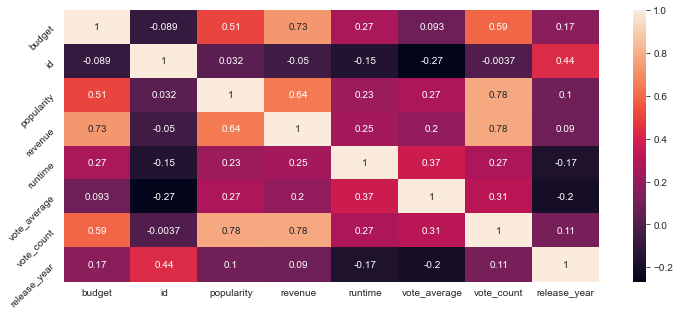

In [33]:
corr_matrix = df_movies.corr()
fig, axs = plt.subplots(figsize=(12,5))

sn.heatmap(corr_matrix, annot=True, ax=axs)
axs.set_yticklabels(corr_matrix.index, rotation=45, ha='right')
axs.set_xticklabels(corr_matrix.index, rotation=0, ha='center')
plt.show();

### 1. Which gender is the most frequent?

Convert json columns in dataframes with key equal to movie id, necessary when I merge the both dataframes

In [34]:
df_genres = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in df_json['genres']], keys=df_json['movie_id'])

Create a combined dataframe of genres and movies

In [35]:
df_gn_cmb = pd.merge(df_genres, df_movies, left_on='movie_id', right_on='id', how='inner',suffixes=('_genres', '_movies'))

Check the datframe size

In [36]:
df_genres.shape, df_gn_cmb.shape

((12160, 2), (12158, 17))

In [37]:
top_genre = df_gn_cmb['name'].value_counts()

In [38]:
top_genre

Drama              2296
Comedy             1722
Thriller           1274
Action             1154
Romance             894
Adventure           789
Crime               696
Science Fiction     535
Horror              519
Family              513
Fantasy             424
Mystery             348
Animation           234
History             197
Music               185
War                 144
Documentary         110
Western              82
Foreign              34
TV Movie              8
Name: name, dtype: int64

In [39]:
top_genre.index[0]

'Drama'

### 2. What is the average budget?

In [40]:
rev_mean = df_movies['revenue'].mean()
rev_mean.round()

82283397.0

### 3. What is the average revenue?

In [41]:
bud_mean = df_movies['budget'].mean()
bud_mean.round()

29054640.0

In [42]:
rev_mean - bud_mean

53228756.585086435

### Plot results of questions 2 and 3

How can wee see in the chart below, overall, these 4801 films generate much more revenue.

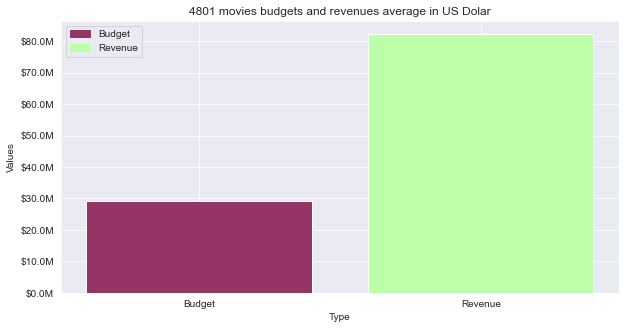

In [43]:
x = np.arange(2)
values = [bud_mean,rev_mean]

# Use function to format the y axis
formatter = FuncFormatter(millions)

my_colors =[[0.58244214, 0.20819484, 0.39943618],[0.73973528, 0.9990836 , 0.66464715]]

c0 = mpatches.Patch(color=my_colors[0], label='Budget')
c1 = mpatches.Patch(color=my_colors[1], label='Revenue')

fig, ax = plt.subplots(figsize=(10,5))
ax.yaxis.set_major_formatter(formatter)
plt.legend(handles=[c0,c1])
plt.bar(x, values, color=my_colors)
plt.xlabel('Type')
plt.ylabel('Values')
plt.title('4801 movies budgets and revenues average in US Dolar')
plt.xticks(x,('Budget','Revenue'));

### 4. Except english, What language is more frequently in the movies?

Summarize languages

In [44]:
name_lang = df_movies.groupby('english_name_of_language')['id'].count()

In [45]:
name_lang

english_name_of_language
Afrikaans                                 1
Arabic                                    2
Bokmål, Norwegian; Norwegian Bokmål       1
Chinese                                  39
Czech                                     2
Danish                                    7
Dutch; Flemish                            4
English                                4504
French                                   70
German                                   27
Greek, Modern (1453-)                     1
Hebrew                                    3
Hindi                                    19
Hungarian                                 1
Icelandic                                 1
Indonesian                                2
Italian                                  14
Japanese                                 16
Kirghiz; Kyrgyz                           1
Korean                                   11
Norwegian                                 1
Persian                                   4
Polish 

In [46]:
# top 10 languages
top_10_lang = name_lang.sort_values(ascending=False).head(11)

# drop english language
exclude_en = top_10_lang.index.values != 'English'
top_10_lang = top_10_lang[exclude_en]

### Plot bar chart

English language holds a majority of movies, then, when we remove it, we can see how much other countries are producing movies.

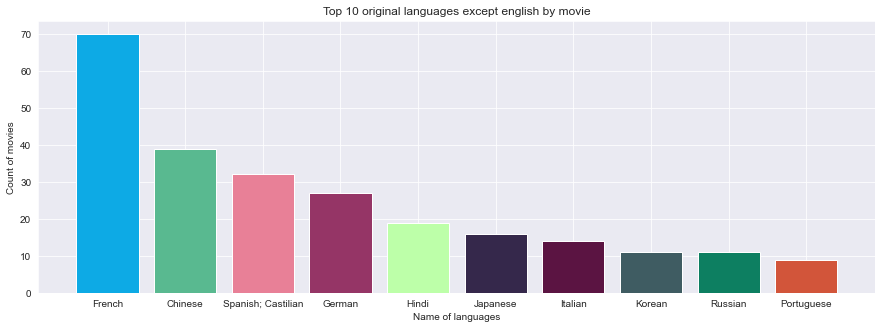

In [47]:
fig,ax = plt.subplots(figsize=(15,5))
locations = np.arange(10)

# use the np function to generate random colors: np.random.rand(len(top_10_lang),3)
my_colors = [[0.05229528, 0.66641006, 0.89907172],
       [0.34948318, 0.72428393, 0.56622149],
       [0.90990714, 0.50172924, 0.59160285],
       [0.58244214, 0.20819484, 0.39943618],
       [0.73973528, 0.9990836 , 0.66464715],
       [0.20700028, 0.1582801 , 0.29224259],
       [0.35547718, 0.07945828, 0.25838442],
       [0.24748145, 0.35897631, 0.3850589 ],
       [0.05013265, 0.49792899, 0.38049825],
       [0.82505185, 0.33143539, 0.22681774]]

heights = top_10_lang
labels = top_10_lang.index
plt.bar(locations, heights, tick_label=labels, color=my_colors)
plt.title('Top 10 original languages except english by movie')
plt.xlabel('Name of languages')
plt.ylabel('Count of movies');

### Pie version of chart above 

In this version, it easy to look the diferences with percentage values

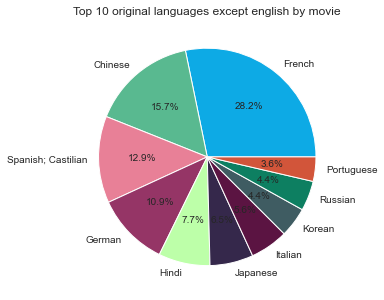

In [48]:
fig = plt.subplots(figsize=(15,5))
heights = top_10_lang
labels = top_10_lang.index
plt.title('Top 10 original languages except english by movie')
plt.pie(heights, labels=labels,autopct='%1.1f%%', colors=my_colors);

### 5. Do high-budget movies have more or less producers involved? What about low budget films?

Get mean value from budget

In [49]:
bud_mean = df_movies['budget'].mean().round()

Select movies with budget is greater than budget mean

In [50]:
movies_high_bud = df_movies.query("budget > @bud_mean")

Get bins from movies to make budget levels

In [51]:
movies_high_bud.budget.describe()

count    1.598000e+03
mean     7.182385e+07
std      4.570849e+07
min      3.000000e+07
25%      4.000000e+07
50%      5.700000e+07
75%      8.500000e+07
max      3.800000e+08
Name: budget, dtype: float64

In [52]:
budg_bins = [3.000000e+07,5.700000e+07,8.500000e+07,3.800000e+08]
budg_lbl = ['Low budget','Mediun budget','High budget']

# Create levels of budget
# The include_lowest parameter is to ensure the minimum value
movies_high_bud['budget_levels'] = pd.cut(movies_high_bud['budget'],bins=budg_bins, labels=budg_lbl,include_lowest=True)

<ipython-input-52-78f026802a39>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_high_bud['budget_levels'] = pd.cut(movies_high_bud['budget'],bins=budg_bins, labels=budg_lbl,include_lowest=True)


In [53]:
movies_high_bud['budget_levels'].value_counts()

Low budget       800
Mediun budget    409
High budget      389
Name: budget_levels, dtype: int64

Get production companies by movies.

Convert json columns in dataframes with key equal to movie id, necessary when I merge the both dataframes

In [54]:
df_prod_comp = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in df_json['production_companies']], keys=df_json['movie_id'])

Create a combined dataframe of producers and movies

In [55]:
df_pc_cmb = pd.merge(df_prod_comp, movies_high_bud, left_on='movie_id', right_on='id', how='inner', suffixes=('_prod_comp', '_movies'))

Check the datframe size

In [56]:
df_prod_comp.shape, df_pc_cmb.shape

((13677, 2), (5668, 18))

In [57]:
df_pc_cmb.head()

,name,id_prod_comp,budget,homepage,id_movies,original_language,original_title,popularity,release_date,revenue,runtime,status,title,vote_average,vote_count,release_year,english_name_of_language,budget_levels
0,Ingenious Film Partners,289.0,237000000.0,Yes,19995,en,Avatar,150.437577,2009-12-10,2.787965e+09,162,Released,Avatar,7.2,11800,2009,English,High budget
1,Twentieth Century Fox Film Corporation,306.0,237000000.0,Yes,19995,en,Avatar,150.437577,2009-12-10,2.787965e+09,162,Released,Avatar,7.2,11800,2009,English,High budget
2,Dune Entertainment,444.0,237000000.0,Yes,19995,en,Avatar,150.437577,2009-12-10,2.787965e+09,162,Released,Avatar,7.2,11800,2009,English,High budget
3,Lightstorm Entertainment,574.0,237000000.0,Yes,19995,en,Avatar,150.437577,2009-12-10,2.787965e+09,162,Released,Avatar,7.2,11800,2009,English,High budget
4,Walt Disney Pictures,2.0,300000000.0,Yes,285,en,Pirates of the Caribbean: At World's End,139.082615,2007-05-19,9.610000e+08,169,Released,Pirates of the Caribbean: At World's End,6.9,4500,2007,English,High budget


Sumarize levels

In [58]:
bud_lvl_prod = df_pc_cmb.groupby('budget_levels')['name'].count()
bud_lvl_prod

budget_levels
Low budget       2682
Mediun budget    1490
High budget      1496
Name: name, dtype: int64

### Plot bar chart

Here, we can think that low budget films may need more help, so they involve more producers or perhaps they do not provide a more specialized service, which justifies the involvement of more producers.

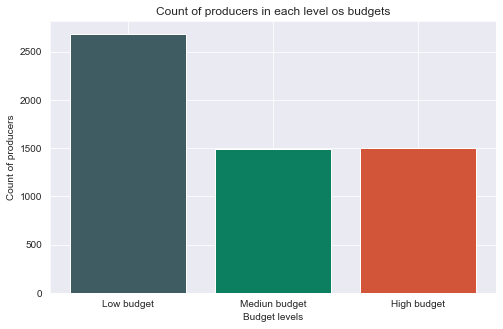

In [59]:
fig, axs = plt.subplots(figsize=(8,5))

locations = np.arange(len(bud_lvl_prod))
values = bud_lvl_prod

my_colors = [[0.24748145, 0.35897631, 0.3850589 ],
            [0.05013265, 0.49792899, 0.38049825],
            [0.82505185, 0.33143539, 0.22681774]]

labels = bud_lvl_prod.index
plt.bar(locations,values, tick_label = labels, color=my_colors)
plt.title('Count of producers in each level os budgets')
plt.xlabel('Budget levels')
plt.ylabel('Count of producers');

### 6. Which genre is associated with the best average vote? And with the smallest?

Get the movie vote average sumarized by genre

In [60]:
genre_votes = df_gn_cmb.groupby('name')['vote_average'].mean().sort_values(ascending=False)
genre_votes

name
History            6.719797
War                6.713889
Drama              6.388284
Music              6.355676
Foreign            6.352941
Animation          6.341453
Crime              6.274138
Documentary        6.238182
Romance            6.207718
Mystery            6.183908
Western            6.178049
Adventure          6.155767
Fantasy            6.096698
Family             6.029630
Thriller           6.010989
Science Fiction    6.005607
Action             5.989515
Comedy             5.945587
TV Movie           5.662500
Horror             5.626590
Name: vote_average, dtype: float64

History and War movies may be more difficult to produce, as they are often true stories and may need more realistic special effects, and maybe that's why people tend to give better classifications. Horror movies are about fear and bad things, so maybe the rating is low.

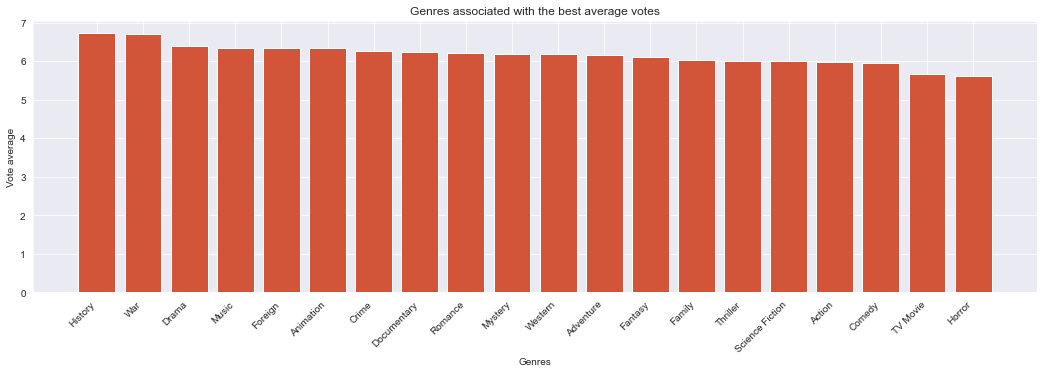

In [61]:
fig, ax = plt.subplots(figsize=(18,5))

locations = np.arange(len(genre_votes))
values = genre_votes
labels = genre_votes.index
plt.bar(locations, values, tick_label=labels, color=[0.82505185, 0.33143539, 0.22681774])
plt.title('Genres associated with the best average votes')
plt.xlabel('Genres')
plt.ylabel('Vote average')
ax.set_xticklabels(labels, rotation=45, ha="right");

### 7. What is the characteristics of movies that have and do not have webpages?

Get the main characteristics of movies in web

In [62]:
movies_in_web = df_movies.query("homepage == 'Yes'")

Popularity and votes averages is higher in percentiles, maybe because the interation of webiste with people.

In [63]:
# Movies with website
movies_in_web[['budget','revenue','runtime','popularity','vote_average']].describe()

,budget,revenue,runtime,popularity,vote_average
count,1.712000e+03,1.712000e+03,1712.000000,1712.000000,1712.000000
mean,4.196824e+07,1.395772e+08,108.183995,32.618629,6.244685
std,5.260389e+07,2.315356e+08,19.781374,46.120602,1.067383
min,0.000000e+00,0.000000e+00,0.000000,0.010909,0.000000
25%,4.500000e+06,2.765780e+06,95.000000,8.830353,5.700000
50%,2.200000e+07,4.978986e+07,105.000000,21.813376,6.300000
75%,6.000000e+07,1.634997e+08,120.000000,42.776643,6.900000
max,3.800000e+08,2.787965e+09,201.000000,875.581305,8.400000


In [64]:
# Get the main characteristics of movies not in web
movies_notin_web = df_movies.query("homepage == 'No'")

The popularity average is much more lower in percentiles than movies with websites, maybe because have one less mean of communications (websites)?

In [65]:
# Movies with not website
movies_notin_web[['budget','revenue','runtime','popularity','vote_average']].describe()

,budget,revenue,runtime,popularity,vote_average
count,3.089000e+03,3.089000e+03,3089.000000,3089.000000,3089.000000
mean,2.189760e+07,5.052973e+07,106.187116,15.337614,6.009291
std,3.002447e+07,9.332353e+07,23.933575,16.995322,1.247329
min,0.000000e+00,0.000000e+00,0.000000,0.000372,0.000000
25%,0.000000e+00,0.000000e+00,93.000000,3.656491,5.500000
50%,1.000000e+07,1.033748e+07,103.000000,9.799177,6.200000
75%,3.025000e+07,6.037858e+07,116.000000,20.716023,6.800000
max,2.250000e+08,8.766885e+08,338.000000,139.575085,10.000000


### 8. Do long runtime movies have low or high average votes?

Get average from votes and runtime fields

In [66]:
vote_avg_mean = df_movies['vote_average'].mean()
runtime_mean = df_movies['runtime'].mean()

Get only movies with runtime is hight than runtime mean

In [67]:
long_runtime = df_movies.query("runtime > @runtime_mean")

Calculate the difference of votes between long runtime average movies and general average votes 

In [68]:
long_runtime['vote_average'].mean() - vote_avg_mean

0.4257689420363855

### 9. Which films are associated with the most used keyword?

The objective of this question is create a list of movies related with the most used keyword.

Get keywords by movies.

Convert json columns in dataframes with key equal to movie id, necessary when I merge the both dataframes.

In [69]:
df_keywords = pd.concat([pd.DataFrame(pd.json_normalize(x)) for x in df_json['keywords']], keys=df_json['movie_id'])

Create a combined dataframe of keywords and movies

In [70]:
df_kw_cmb = pd.merge(df_keywords,df_movies, left_on='movie_id', right_on='id', suffixes=('_keywords','_movies')).copy()

Check the datframe size

In [71]:
df_keywords.shape, df_kw_cmb.shape

((36194, 2), (36189, 17))

Get the classify of movies keywords

In [72]:
movies_kw = df_kw_cmb.groupby('name')['name'].value_counts().sort_values(ascending=False)

Get the top keyword

In [73]:
top_kw = movies_kw.index[0][0]
top_kw 

'woman director'

Select movies with top keyword

In [74]:
kw_movies = df_kw_cmb.query("name == @top_kw").groupby('title')['id_movies'].value_counts()

In [75]:
# Store data in a list
lst_movies = []
for i,j in kw_movies.index:
    lst_movies.append(i)

List of 324 movies with woman director keyword

In [76]:
len(lst_movies)

324

Show list of movies

In [77]:
lst_movies

['16 to Life',
 '200 Cigarettes',
 '27 Dresses',
 '28 Days',
 'A League of Their Own',
 'A Tale of Three Cities',
 'Across the Universe',
 'Adore',
 'After.Life',
 'Aloft',
 'Alvin and the Chipmunks: The Squeakquel',
 'American Psycho',
 'American Splendor',
 'An Education',
 'Antarctic Edge: 70° South',
 'Aquamarine',
 'Archaeology of a Woman',
 'Aroused',
 'Arthur Christmas',
 'August Rush',
 'Autumn in New York',
 'B-Girl',
 'Bachelorette',
 'Bend It Like Beckham',
 'Beyond the Lights',
 'Big',
 'Black Nativity',
 'Black Rock',
 'Blood and Chocolate',
 'Blue Car',
 'Born Of War',
 'Born to Fly: Elizabeth Streb vs. Gravity',
 'Bound',
 "Boys Don't Cry",
 'Bran Nue Dae',
 'Brave',
 'Brick Lane',
 'Bride & Prejudice',
 "Bridget Jones's Diary",
 'Bridget Jones: The Edge of Reason',
 'Bright Star',
 'Burn',
 "But I'm a Cheerleader",
 'Butterfly Girl',
 'By the Sea',
 'Cadillac Records',
 "Can't Hardly Wait",
 "Can't Stop the Music",
 'Caramel',
 'Carrie',
 'Censored Voices',
 'Chasing Pa

<a id='conclusions'></a>
## Conclusions

I discover that the most populars genres is Drama, History and War.

The Drama genre is most frequent and History and War is related with the best vote averages. Curiously, horror genre is worst rated but not the less frequent.

About budget and revenue averages for all movies, the revenue is approximately 53 milions  higher than budget.

There are much more producers involved with low-budget films.

Looking the percentiles of movies with have website, the popularity and votes averages is higher than movies that don't have websites.

Movies with runtime higher than average have 0.42 votes higher than low runtime movies.

The keyword 'woman director' is present in more than 300 movies. I created a list of these films for those interested in watching. Congratulations to the women's.

### Limitations

In Data Wrangling section, JSON content was a limiter because its necessary decode,preparate and separate the data. On the other hand, JSON was necessary to ensure unique movies in each row. I expected to find 5000 rows in dataset, but found 4803 with some null values. At the end of cleaning, 4801 rows reamained because I fill values on fields with many null values to not lose more movies. In the original_language field have a strange data lik 'xx' and I remove because not finda the meaning.

In EDA section, fields like average votes and popularity are not updated, so this analysis don't show the real status of this fields in TMDB website. In the runtime it was necessary fill two null values with geral average.